# Ch3: Classification
Use MNIST Dataset to perform handwritten digit classification.

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
#Sk learn provides easy ways to download popular datasets.
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X,  y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70K images, and each pixel has 784 features (1 per pixel, intensity measure)

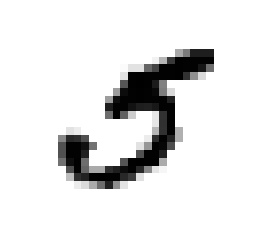

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
#What does the label for this example say? It aught to be a "5"
y[36000]

5.0

As usual, before we do anything, we should split the data into a test and training set, and ignore the test set until the end.

In [8]:
#MNIST is already split for us, 60K/10K
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
#Shuffle the training set, for Cross validation purposes
import numpy as np
shuffle_index =  np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index],y_train[shuffle_index]

## Training a Binary Classifier
We will make a "5 detector". Is it a 5 or not, aka binary classifier.
We'll use the sklearn "Stochastic Gradient Descent" classifier (SGD)

In [14]:
y_train

array([9., 4., 2., ..., 7., 6., 6.])

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [27]:
#I was confused how this works. numpy arrays make it happen.
a = (np.array([1,2,2,3]) == 2)
a

array([False,  True,  True, False])

In [37]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [25]:
sgd_clf.predict([some_digit])

array([False])

## Evaluating Performance of Classifiers.
Classifier evaluation can be trickier than regressor validation. Here are techniques

### Cross Validation
You can gain more control over cross validation than what sklearn provides by making it on your own (if you need to).

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#Performs Stratified Sampling, to ensure each set is representative.
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9273
0.95935
0.9431


In [39]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9273 , 0.95935, 0.9431 ])

Performance looks great! (above 90%). Lets make a small classifier to see if this is too good to be true.

In [33]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # Always predict "not a 5". Genius.
        return np.zeros((len(X),1), dtype=bool)

In [34]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90685, 0.90985, 0.91225])

Above 90% even on the fake classifier. Why? Only 10% of the images are 5's so if you guess never 5, then you get 90% accuracy.... hmm.

This shows that you should be wary of the "accuracy" measure on skewed datasets (aka some classes more frequent than others).

### Confusion Matrix
Count the number of times Class A is classified as Class B, and so forth.

In [40]:
from sklearn.model_selection import cross_val_predict

#Performs K-Fold cross validation, but returns predictions instead of scores.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52914,  1665],
       [ 1740,  3681]])

What does this show? Each row is an actual class (5, not5) and each column is the predicted class.

First row is the "Not5" class, which shows 52K were correctly identified as Not5, and 1.6K were misIdentified.

1740 were incorrectly identified as 5s (false positive) while 3681 were correctly shown to be 5 (aka true positive).

In [42]:
#If you were perfect it would look like this
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall
precision = TP / (TP + FP)

TP: true positive. FP: false positive.

recall = TP / (TP + FN)
FN: false negative.
Recall is ratio of positive instances that are correctly detected.

In [43]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.6885521885521886

In [45]:
recall_score(y_train_5, y_train_pred)

0.6790260099612617

This is a better metric than accuracy. We can see that when we say "5" we are correct 68% of the time. We also only detect 67% of the 5's.

You can combine precision and recall into a single metric called the F1 score. F1 is the harmonic mean of precision anrd recall. F1 will only be high if both recall and precision are high.

In [46]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6837559208693229

F1 is great for when you want both high precision and recall, which may not always be true. If you only care about precision, (like classifying innapropriate videos for children), you accept having some ok videos rejected for the sake of accuracy of predicting bad ones.

Recall would be more important for a shoplifting detecting security camera. (aka some false alarms will happen, but 99% of shoplifters could get caught).

SGDClassifier computes a score based on a decision function, which lets it determine the class of an example. There is also a 'decision threshold' for that score, to determine the class.

Moving this threshold represents the Precision/Recall tradeoff.

In [48]:
#You can get access to the decision function of the SGD classifier.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-155387.25826072])

In [52]:
#You could adjust the threshold.
threshold = -200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In this case, lowering threshold increased recall, but would probably decrease accuracy.

In [53]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [54]:
#With these scores, we can plot precision and recall now, to let us decide what our threshold should be.
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

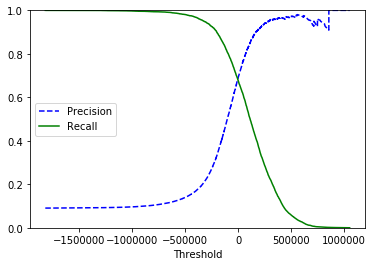

In [58]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [63]:
#Lets say we want 90% precision or so. Zoom in on the graph to find what threshold that corresponds to.
#Lets see how it does.
y_train_pred_90 = (y_scores > 90000)
precision_score(y_train_5, y_train_pred_90)

0.8238269176735038

In [64]:
recall_score(y_train_5, y_train_pred_90)

0.5408596199963106

If someone says "Lets get 99% precision", you should ask "at what recall?"

### The ROC Curve
Receiver Operating Characteristic. Plots true positive rate (recall) against false positive rate. True negative rate is "specificity". ROC plots "sensitivity" (recall) vs (1- specificity)

In [65]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [66]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

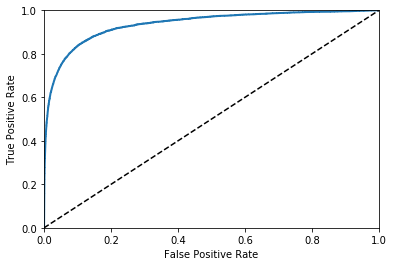

In [67]:
plot_roc_curve(fpr,tpr)
plt.show()

Higher the recall (TPR), the higher the FPR (false positives). Dotted line is the purely random classifier. You want to stay as far away from that line as possible. (top left corner).

You can measure area under the ROC curve to compare classifiers. Perfect ROC area will be 1. Random is .5.

In [68]:
#compute ROC AUC (area under curve)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9363861476682956

Generally prefer PR curve to ROC when positive class is rare, or when you care more about false positives than false negatives. ROC curve otherwise.

In [75]:
#Train and compare Random Forest to SGD Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [76]:
#Random forest uses a predict_proba method instead of decision_function 
#(aka probablility that the image represents a 5)
#To make the plot, we need to convert probas into scores.
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

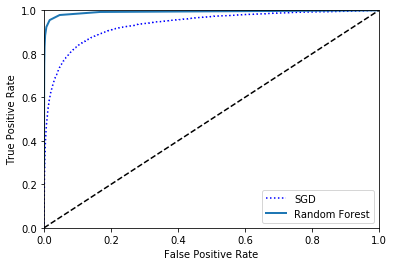

In [77]:
plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [78]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926390773271558

ROC AUC is better for forest, and the curve looks better (tighter to upper left). Lets check out the precision and recall of the forest classifier.

In [80]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9829805804058477

In [81]:
recall_score(y_train_5, y_train_pred_forest)

0.8310274857037447

## Multiclass Classification
aka Multinomial classifiers distinguish between several things, instead of just two.

Some algorithms supplort multiclass but some are binary only.

You can create a multiclass classifier from several binary classifiers. run them all and then select highest score (One vs All, OvA or One verses Rest strat).

Or train several pairs of binary classifiers (distinguish 0 vs 1, 0 vs 2, 1 vs 2, 1 vs 3, etc). for MNIST this would require 45 binary classifiers. This is called One versus One (OvO) strategy.

In [82]:
#sklearn detects when you are doing binary vs multiclass and handles it automatically.
sgd_clf.fit(X_train, y_train) #not y_train_5)
sgd_clf.predict([some_digit])

array([0.])

*For some reason my some_digit doesnt work in this notebook.*

In [83]:
# To see that there are 10 binary classifiers under the hood you can look at the decision_function outputs.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-132902.15084819, -551464.96129195, -149606.03371551,
        -174937.66000917, -499355.9464999 , -155387.25826072,
        -663476.08037814, -245906.37272723, -630345.52829456,
        -683039.65807054]])

In [84]:
np.argmax(some_digit_scores)

0

In [85]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [87]:
#You can force OvO or OvA
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

Yay that time it worked.

In [89]:
len(ovo_clf.estimators_) #Just like we predicted, 45 OvO binary classifiers.

45

In [92]:
#multiclass random forest
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
#we didn't have to do OvO or OvA because random forest alg supports multiclass natively.

array([5.])

In [93]:
forest_clf.predict_proba([some_digit])
#probabilities that this digit is each class, 0-9

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [94]:
#Lets do our normal evaluation using cross val.
#remember sklearn implicitly makes sgd do OvO or OvA under the hood.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86937612, 0.78818941, 0.85632845])

In [96]:
#How does scaling affect accuracy?
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [97]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90791842, 0.91189559, 0.90983648])

Even better.

## Error Analysis